In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, StandardScaler

In [3]:
## Load the NN emulator `speculator`
with open('./speculator_best_recon_model_TZD.pkl', 'rb') as f:
    speculator = pickle.load(f)

speculator.params_name += ['logm', 'redshift']
speculator._build_params_prior()
speculator.bounds = np.array([speculator.prior[key] for key in speculator.params_name])
# speculator.network.eval();

noise = 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

In [4]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [5]:
def gen_truth(sfh_kwargs, logz_logm_kwargs, 
              dust2_kwargs, redshift_kwargs, 
              nsamples=5000, random_state=None):
    from torch.distributions import MultivariateNormal
    if random_state is not None:
        torch.manual_seed(random_state)
    y_sfh = MultivariateNormal(torch.Tensor(sfh_kwargs['loc']), 
                               covariance_matrix=torch.Tensor(sfh_kwargs['cov'])
                              ).sample(sample_shape=(nsamples,))
    
    y_logz_logm = MultivariateNormal(torch.Tensor(logz_logm_kwargs['loc']), 
                                     torch.Tensor(logz_logm_kwargs['cov'])
                                    ).sample(sample_shape=(nsamples // 2,))
    y_logz_logm = torch.vstack([y_logz_logm, MultivariateNormal(torch.Tensor([-0.5, 8.5]), 
                             torch.Tensor(logz_logm_kwargs['cov']) * 0.5,
                            ).sample(sample_shape=(nsamples // 2,))])

    y_dust2 = torch.normal(mean=dust2_kwargs['mean'], std=dust2_kwargs['std'], size=(nsamples, 1))
    y_redshift = torch.normal(mean=redshift_kwargs['mean'], std=redshift_kwargs['std'], size=(nsamples, 1))
    
    Y_truth = torch.hstack([y_sfh, y_logz_logm[:, 0:1], y_dust2, y_logz_logm[:, 1:], y_redshift]).to('cuda')
    return Y_truth

In [6]:
sfh_kwargs = {'loc': [6, 0], 'cov': [[1, 0], [0, 0.3]]}
logz_logm_kwargs = {'loc': [-0.5, 10.5], 
                    'cov': [[0.3, 0.2], 
                            [0.4, 0.6]]}
dust2_kwargs = {'mean': 1, 'std': 0.5}
redshift_kwargs = {'mean': 0.15, 'std': 0.03}

In [7]:
Y_truth = gen_truth(sfh_kwargs, logz_logm_kwargs, 
                    dust2_kwargs, redshift_kwargs,
                    nsamples=5000, random_state=None)

In [8]:
filters = ['sdss_{0}0'.format(b) for b in 'ugriz']
# filters = ['hsc_{0}'.format(b) for b in 'grizy']
# filters = ['galex_NUV'] + ['hsc_{0}'.format(b) for b in 'grizy'] + ['jwst_f090w', 'jwst_f115w', 'jwst_f140m']

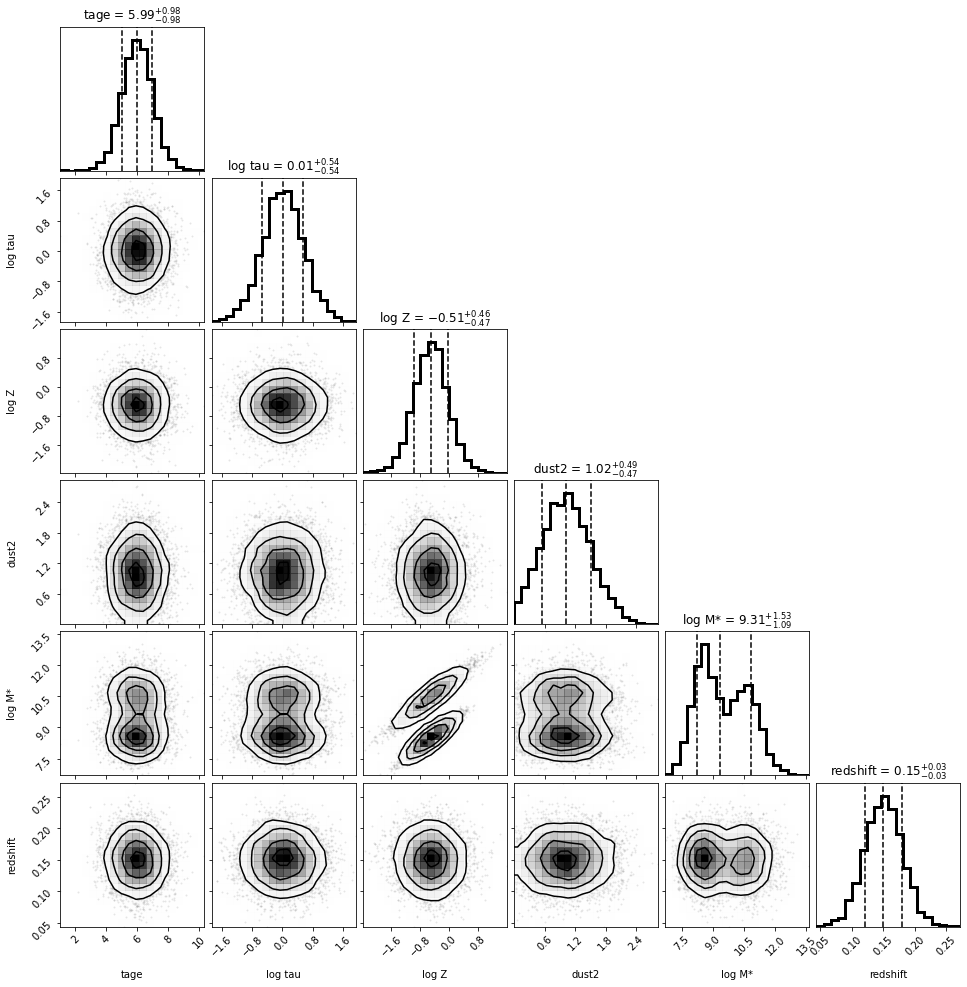

In [9]:
X_data = speculator._predict_mag_with_mass_redshift(
    Y_truth,
    filterset=filters,
    noise=noise, 
    noise_model_dir=noise_model_dir)
flag = ~(torch.isnan(X_data).any(dim=1) | torch.isinf(X_data).any(dim=1))
flags = [((Y_truth[:, i] < speculator.bounds[i, 1]) & (Y_truth[:, i] > speculator.bounds[i, 0])).cpu().numpy()
 for i in range(len(speculator.bounds))]
flag = flag.cpu().numpy() & np.array(flags).all(axis=0)

X_data = X_data[flag].detach()
Y_truth = Y_truth[flag]

figure = corner.corner(Y_truth.cpu().detach().numpy(),
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=['tage', 'log tau', 'log Z', 'dust2', 'log M*', 'redshift'],
                       smooth=0.7,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

In [11]:
filelist = os.listdir('./nde_theta_TZD_sdss_noise_uniform_prior_broad/')#[:6]
filelist

['nde_theta_best_loss_nsf_77.pkl',
 'nde_theta_best_loss_nsf_550.pkl',
 'nde_theta_best_loss_nsf_826.pkl',
 'nde_theta_best_loss_nsf_336.pkl',
 'nde_theta_best_loss_nsf_983.pkl',
 'nde_theta_best_loss_nsf_923.pkl',
 'nde_theta_best_loss_nsf_577.pkl',
 'nde_theta_best_loss_nsf_953.pkl',
 'nde_theta_best_loss_nsf_898.pkl',
 'nde_theta_best_loss_nsf_334.pkl',
 'nde_theta_best_loss_nsf_371.pkl',
 'nde_theta_best_loss_nsf_925.pkl',
 'nde_theta_best_loss_nsf_124.pkl',
 'nde_theta_best_loss_nsf_511.pkl',
 'nde_theta_best_loss_nsf_894.pkl',
 'nde_theta_best_loss_nsf_259.pkl',
 'nde_theta_best_loss_nsf_846.pkl',
 'nde_theta_best_loss_nsf_193.pkl',
 'nde_theta_best_loss_nsf_484.pkl',
 'nde_theta_best_loss_nsf_367.pkl']

In [12]:
len(filelist)

20

In [13]:
# This is slow
NDE_list = []
for file in filelist:
    try:
        NDE = pickle.load(open('./nde_theta_TZD_sdss_noise_uniform_prior_broad/' + file, 'rb'))
        if NDE.best_model.vali_loss_history[-1] < 0.15:
            NDE_list.append(NDE)
        else:
            print('Remove', file)
    except Exception as e:
        print(file, e)
        continue

Remove nde_theta_best_loss_nsf_550.pkl


In [14]:
vali_loss = [NDE.best_model.vali_loss_history[-1] for NDE in NDE_list]
vali_loss

[0.13943758606910706,
 0.06916768103837967,
 0.057969529181718826,
 0.06476471573114395,
 0.1257011443376541,
 0.05849425122141838,
 0.13966353237628937,
 0.05860385298728943,
 0.12803402543067932,
 0.06029581278562546,
 0.0568813681602478,
 0.07318545132875443,
 0.06402015686035156,
 0.06331994384527206,
 0.07988618314266205,
 0.1208198294043541,
 0.10309257358312607,
 0.08167948573827744,
 0.06460180878639221]

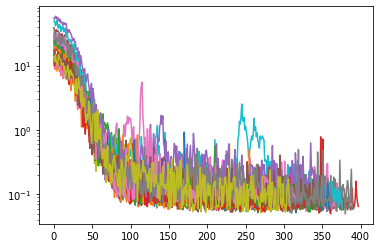

In [15]:
[plt.plot(NDE.vali_loss_history) for NDE in NDE_list]
plt.yscale('log')

In [38]:
# samples = torch.dstack([NDE.best_model.sample(1500) for NDE in NDE_list[0:21] + NDE_list[22:]])
samples = torch.dstack([NDE.best_model.sample(1500) for NDE in NDE_list[:15]]) #  + NDE_list[19:]

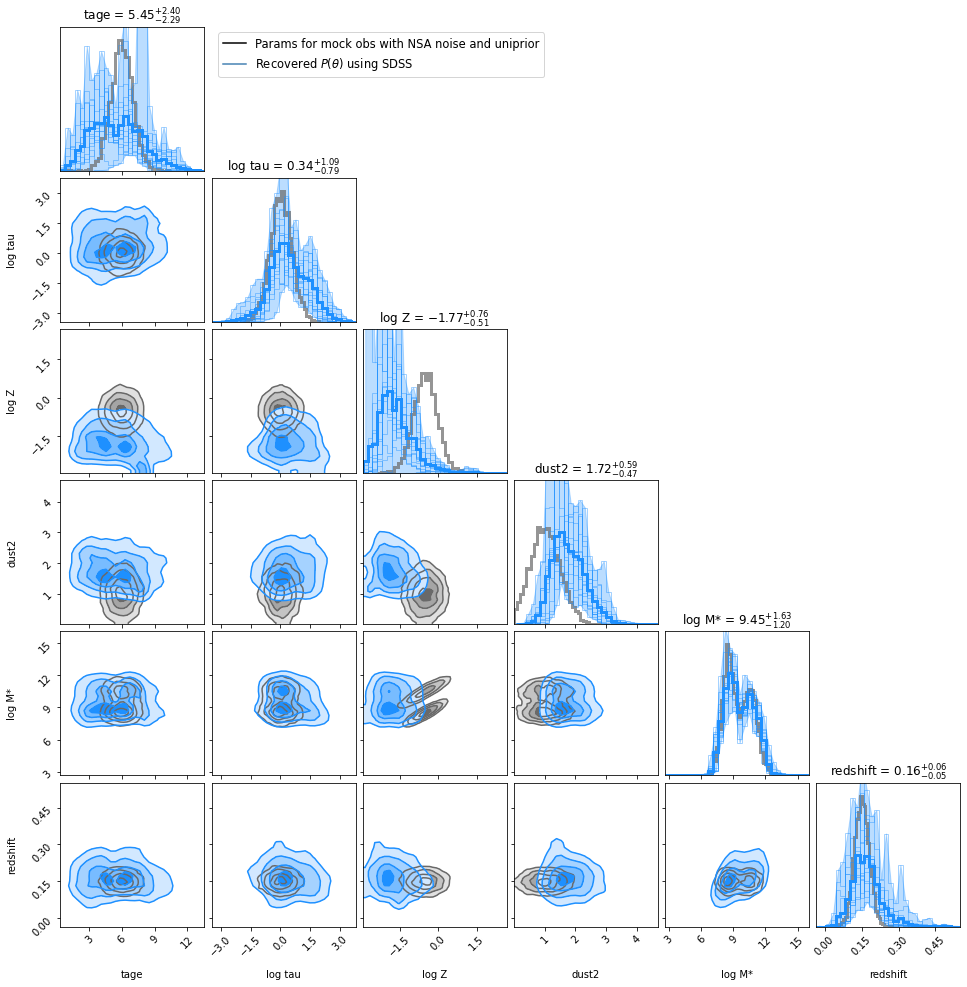

In [39]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs with NSA noise and uniprior')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using SDSS')

labels = ['tage', 'log tau', 'log Z', 'dust2', 'log M*', 'redshift']

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=30,
                       smooth=0.8, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True, 'lw': 1.5, 'alpha': 0.7}, 
                       plot_datapoints=False)

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                        fig=figure, labels=labels, bins=30,
                        color='dodgerblue',
                        smooth=0.8, fill_contours=True,
                        show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True, 'lw': 1.}, 
                        plot_datapoints=False)
ax = nf_plot.get_axes()[2]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [40]:
# sample the initial setups
# stds = np.array([1.7, 2, 1, 1, 2, 0.07])
stds = np.array([2, 2, 1, 1, 2, 0.07])

_init_sample = []

for i in range(20):
    _mean = np.zeros(6)
    _mean[0] = np.random.uniform(3, 10)
    _mean[1] = np.random.uniform(-1.5, 1.5)
    _mean[2] = np.random.uniform(-1.5, 1)
    _mean[3] = np.random.uniform(0.1, 2)
    _mean[4] = np.random.uniform(7, 11)
    _mean[5] = np.random.uniform(0.05, 0.3)
    _init_sample.append(np.random.normal(_mean, stds, size=(1000, 6)))

In [41]:
_init_sample = np.array(_init_sample)

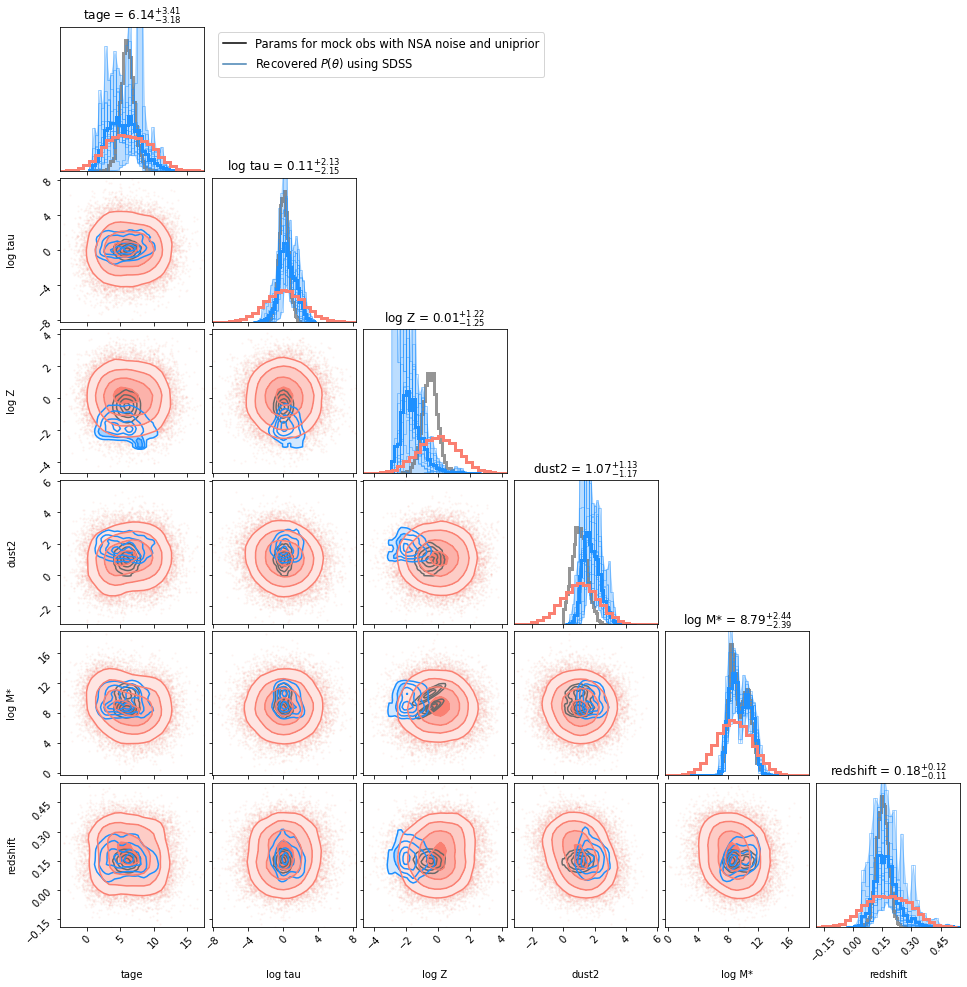

In [42]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs with NSA noise and uniprior')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using SDSS')

labels = ['tage', 'log tau', 'log Z', 'dust2', 'log M*', 'redshift']

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=30,
                       smooth=0.8, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True, 'lw': 1.5, 'alpha': 0.7}, 
                       plot_datapoints=False)

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                        fig=figure, labels=labels, bins=30,
                        color='dodgerblue',
                        smooth=0.8, fill_contours=True,
                        show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True, 'lw': 1.}, 
                        plot_datapoints=False)

_ = corner.corner(_init_sample.reshape(-1, 6), 
                       fig=figure, color='salmon', alpha=0.1, labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.8, fill_contours=True,
                       show_titles=True, 
                       hist_kwargs={'density': True, 'lw': 0.5}, 
                       title_kwargs={"fontsize": 12},
                       plot_datapoints=True)

ax = nf_plot.get_axes()[2]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [37]:
np.log10(L(X_data, torch.Tensor(mags).to('cuda')).item()) # The distance in theta space

-0.9776024742334073

In [45]:
NDE_theta = NDE_list[0]

In [37]:
samples.swapaxes(0, 1).reshape(6, -1).T.shape

torch.Size([14000, 6])

0 1000


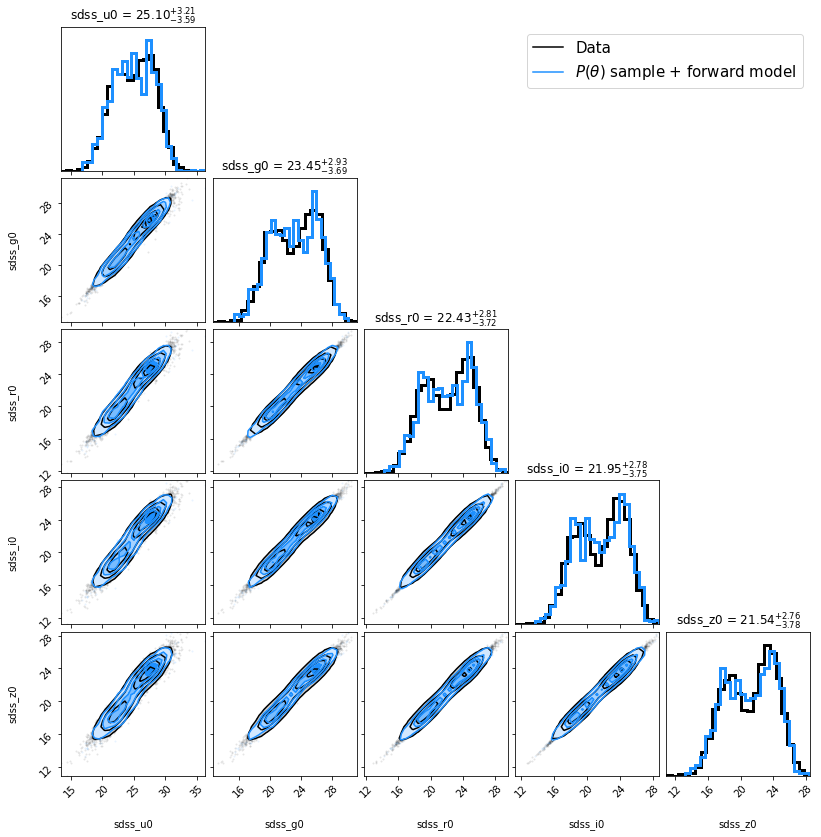

In [43]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = filters

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.7, fill_contours=True,
                       show_titles=True, 
                       hist_kwargs={'density': True, 'lw': 1}, 
                       title_kwargs={"fontsize": 12},
                       plot_datapoints=True)

mags = speculator._predict_mag_with_mass_redshift(samples.swapaxes(0, 1).reshape(6, -1).T,
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~(mags > 45).any(axis=1)]
nf_plot = corner.corner(mags,
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.7, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12},
                        hist_kwargs={'density': True, 'lw': 1}, 
                        plot_datapoints=True)

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))